# Overview

This code implements the PIML regresson procedure described in Wang et al. 2017, with the case of flow over periodic hills as example.

* J.-X. Wang, J.-L. Wu, and H. Xiao. Physics informed machine learning approach for reconstructing Reynolds stress modeling discrepancies based on DNS data. Physical Review Fluids. 2(3), 034603, 1-22, 2017. https://doi.org/10.1103/PhysRevFluids.2.034603[DOI:10.1103/PhysRevFluids.2.034603]

# Algorithm of PIML-Based Turbulence Modeling

The overall procedure can be summarized as follows:

1. Perform baseline RANS simulations on both the training flows and the test flow.
2. Compute the input feature field $q(x)$ based on the local RANS flow variables.
3. Compute the discrepancies field $\Delta \tau (x)$ in the RANS-modeled Reynolds stresses for the training flows based on the high-fidelity data.
4. <b>Construct regression functions $f:q \mapsto \Delta \tau$   for the discrepancies based on the training data prepared in Step 3, using machine learning algorithms.</b>
5. Compute the Reynolds stress discrepancies for the test flow by querying the regression functions. The Reynolds stresses can subsequently be obtained by correcting the baseline RANS predictions with the evaluated discrepancies.
6. Propagate the corrected Reynolds stresses to the mean velocity field by solving the RANS equations with the corrected Reynolds stress field.

<b>This code only performs Step 4.</b> (see the green-shaded box below in the flow chart). The training data prepared in Steps 1-3 are saved in database folder.

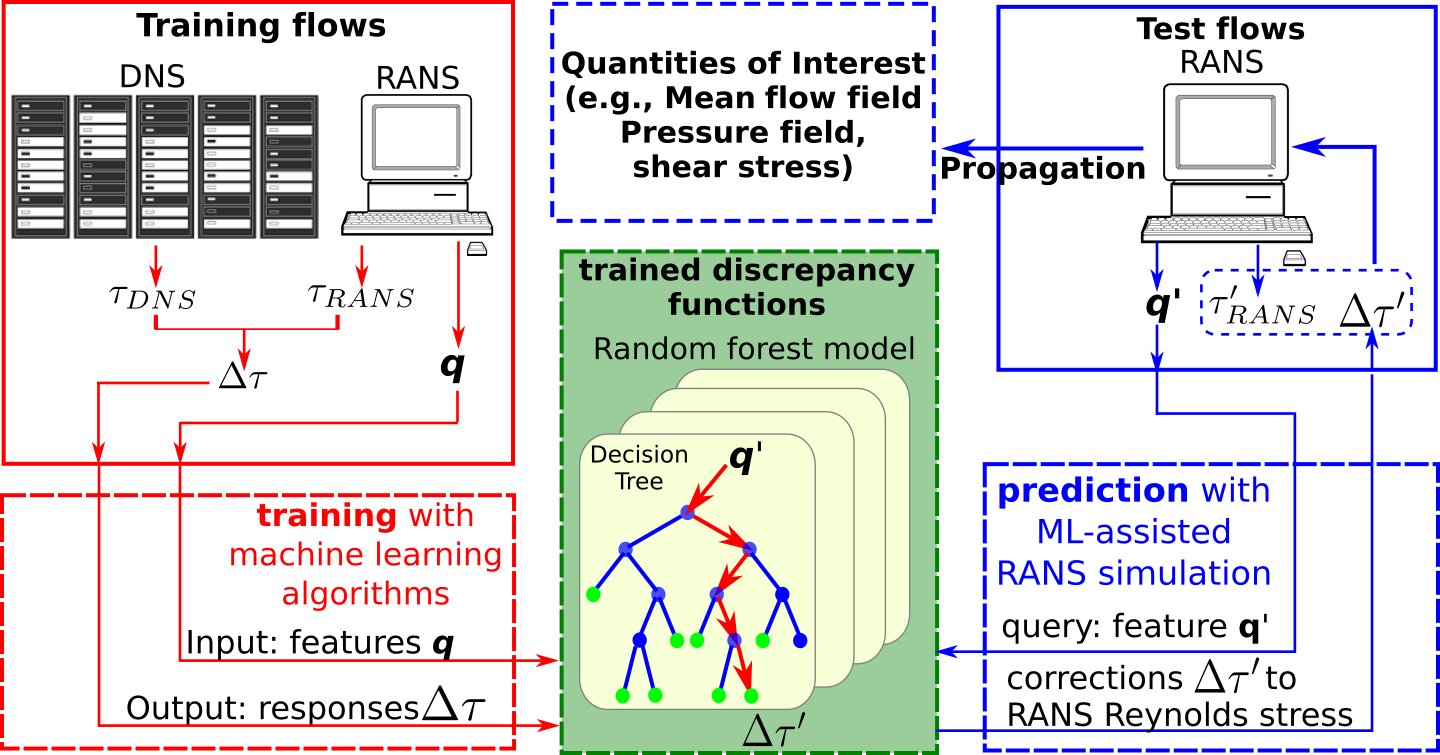

In [8]:
from IPython.display import Image
Image(filename='C:/Users /Desktop/SquareDuct_database/figures/PIML-algorithm.png')


# Machine learning algorithms

The procedure implented here consists of three parts:

1. load training and test data
2. construct regression function $\Delta \tau (q)$ (detailed below)
3. plot the anisotropy parameters $\zeta $ and $\eta$ (components of $\Delta \tau$) and compare with ground truth (DNS)
We used two algorithms to build the regression function:

* Random Forests (based on scikit-learn). This is what was used in Wang et al.
* Neural networks (based on Tensorflow)
Both algorithms yielded similar results, but the former is cheaper computationally.

The input features consist of 12 variables (see Table 1 below and also Wang et al.)

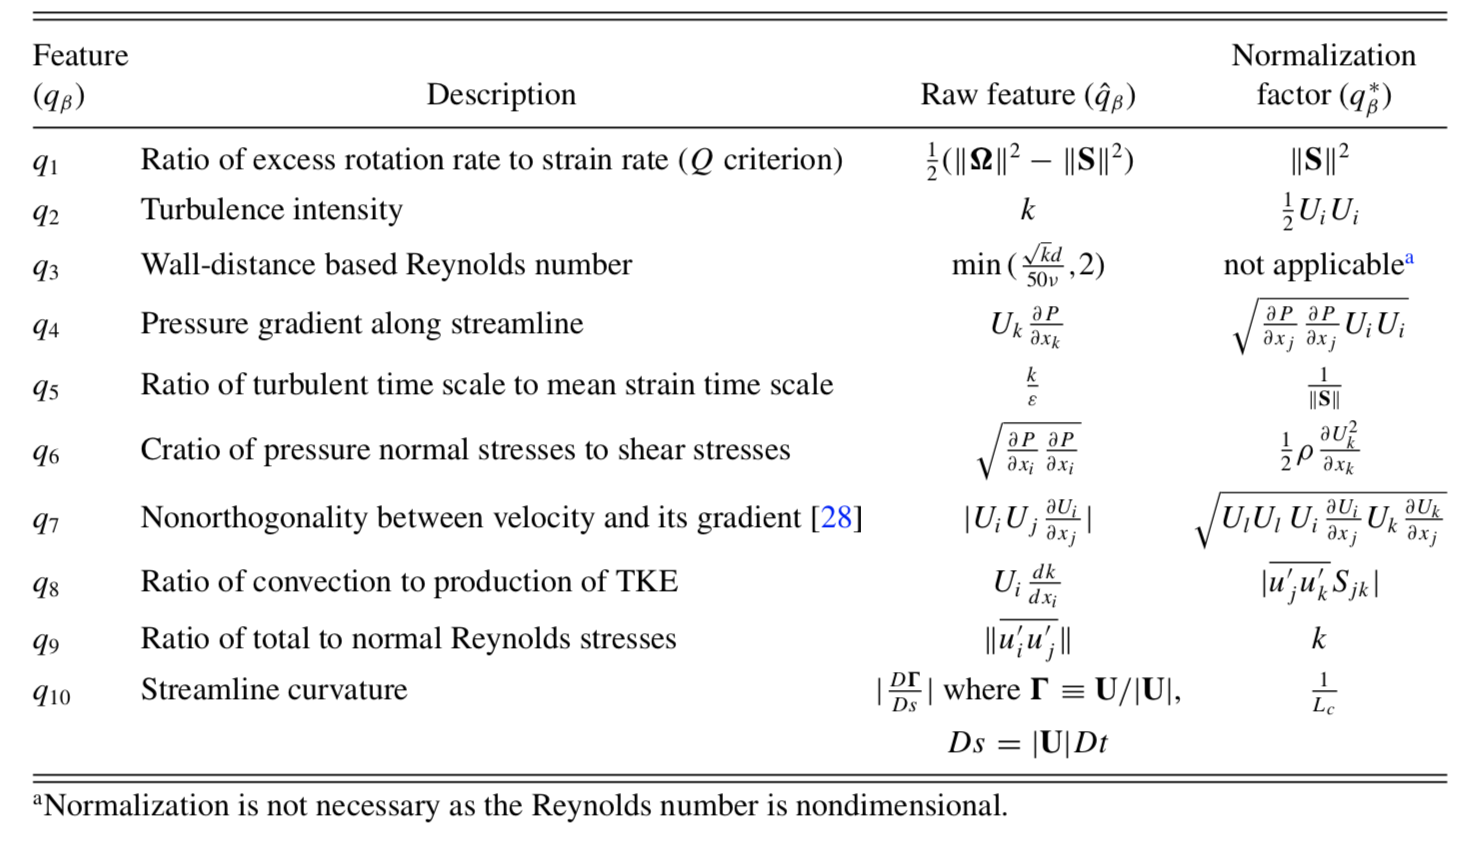

In [9]:
Image(filename='C:/Users /Desktop/SquareDuct_database/figures/features.png')

# Physics of the Problem

The problem is a turbulent fluid flow through a square-section duct. According to the symmetry, only 1/4 of duct is solved. Also, the inlet and outlet of the duct is considered as periodic boundary conditions. The problem is solved using <b>Reynolds Stress Model</b> in $Re=2200, 2600$ and $2900$ as training data and $Re=3500$ as test data. Fluid field data on middle plane of 1/4 duct is exctracted to make features as well as discrepancies between DNS and RSM results. Also, two line ($y/H=0.25$ and $0.75$) is defined to investigate the turbulence anisotropy.

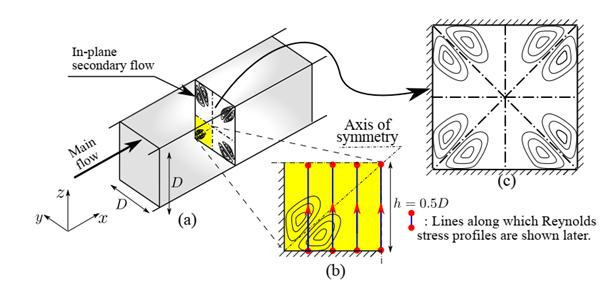

In [10]:
Image(filename='C:/Users /Desktop/SquareDuct_database/figures/physics.png')

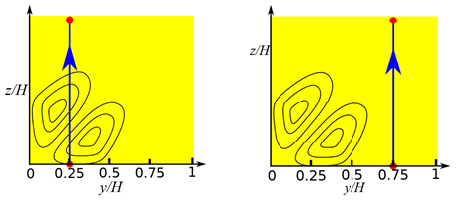

In [11]:
Image(filename='C:/Users /Desktop/SquareDuct_database/figures/location.png')

# Comparison of RSM and DNS results on y/H = 0.25 and 0.75

In [12]:
## Import system modules
# sci computing
import numpy as np
# plotting
import matplotlib.pyplot as plt  # for plotting
#import matplotlib as mp
import matplotlib.font_manager as font_manager

In [13]:
filename = 'C:/Users /Desktop/SquareDuct_database/Projected DNS/Re2200-line-PDNS.txt'
raw_data = open(filename, 'rb')
data = np.loadtxt(raw_data, skiprows=1)
zH2200DNS = data[:,1]
U2200DNS = data[:,2]
V2200DNS = data[:,3]
k2200DNS = 0.5*(data[:,5]+data[:,8]+data[:,10])
uv2200DNS = data[:,6]
uw2200DNS = data[:,7]


#filename = 'C:/Users /Desktop/SquareDuct_database/Projected DNS/Re2200-yH025-PDNS.txt'
#raw_data = open(filename, 'rb')
#data = np.loadtxt(raw_data, skiprows=1)
#zH2200DNS = data[:,1]
#U2200DNS = data[:,2]
#k2200DNS = 0.5*(data[:,5]+data[:,8]+data[:,10])
#uv2200DNS = data[:,6]
#uw2200DNS = data[:,7]

#filename = 'C:/Users /Desktop/SquareDuct_database/Projected DNS/Re2200-yH075-PDNS.txt'
#raw_data = open(filename, 'rb')
#data = np.loadtxt(raw_data, skiprows=1)
#zH2200DNS = np.append(zH2200DNS, data[:,1])
#U2200DNS = np.append(U2200DNS, data[:,2])
#k2200DNS = np.append(k2200DNS, 0.5*(data[:,5]+data[:,8]+data[:,10]))
#uv2200DNS = np.append(uv2200DNS, data[:,6])
#uw2200DNS = np.append(uw2200DNS, data[:,7])

filename = 'C:/Users /Desktop/SquareDuct_database/Projected DNS/Re2600-line-PDNS.txt'
raw_data = open(filename, 'rb')
data = np.loadtxt(raw_data, skiprows=1)
zH2600DNS = data[:,1]
U2600DNS = data[:,2]
V2600DNS = data[:,3]
k2600DNS = 0.5*(data[:,5]+data[:,8]+data[:,10])
uv2600DNS = data[:,6]
uw2600DNS = data[:,7]

#filename = 'C:/Users /Desktop/SquareDuct_database/Projected DNS/Re2600-yH025-PDNS.txt'
#raw_data = open(filename, 'rb')
#data = np.loadtxt(raw_data, skiprows=1)
#zH2600DNS = data[:,1]
#U2600DNS = data[:,2]
#k2600DNS = 0.5*(data[:,5]+data[:,8]+data[:,10])
#uv2600DNS = data[:,6]
#uw2600DNS = data[:,7]

#filename = 'C:/Users /Desktop/SquareDuct_database/Projected DNS/Re2600-yH075-PDNS.txt'
#raw_data = open(filename, 'rb')
#data = np.loadtxt(raw_data, skiprows=1)
#zH2600DNS = np.append(zH2600DNS, data[:,1])
#U2600DNS = np.append(U2600DNS, data[:,2])
#k2600DNS = np.append(k2600DNS, 0.5*(data[:,5]+data[:,8]+data[:,10]))
#uv2600DNS = np.append(uv2600DNS, data[:,6])
#uw2600DNS = np.append(uw2600DNS, data[:,7])


filename = 'C:/Users /Desktop/SquareDuct_database/Projected DNS/Re2900-line-PDNS.txt'
raw_data = open(filename, 'rb')
data = np.loadtxt(raw_data, skiprows=1)
zH2900DNS = data[:,1]
U2900DNS = data[:,2]
V2900DNS = data[:,3]
k2900DNS = 0.5*(data[:,5]+data[:,8]+data[:,10])
uv2900DNS = data[:,6]
uw2900DNS = data[:,7]


#filename = 'C:/Users /Desktop/SquareDuct_database/Projected DNS/Re2900-yH025-PDNS.txt'
#raw_data = open(filename, 'rb')
#data = np.loadtxt(raw_data, skiprows=1)
#zH2900DNS = data[:,1]
#U2900DNS = data[:,2]
#k2900DNS = 0.5*(data[:,5]+data[:,8]+data[:,10])
#uv2900DNS = data[:,6]
#uw2900DNS = data[:,7]

#filename = 'C:/Users /Desktop/SquareDuct_database/Projected DNS/Re2900-yH075-PDNS.txt'
#raw_data = open(filename, 'rb')
#data = np.loadtxt(raw_data, skiprows=1)
#zH2900DNS = np.append(zH2900DNS, data[:,1])
#U2900DNS = np.append(U2900DNS, data[:,2])
#k2900DNS = np.append(k2900DNS, 0.5*(data[:,5]+data[:,8]+data[:,10]))
#uv2900DNS = np.append(uv2900DNS, data[:,6])
#uw2900DNS = np.append(uw2900DNS, data[:,7])

filename = 'C:/Users /Desktop/SquareDuct_database/Projected DNS/Re3500-line-PDNS.txt'
raw_data = open(filename, 'rb')
data = np.loadtxt(raw_data, skiprows=1)
zH3500DNS = data[:,1]
U3500DNS = data[:,2]
V3500DNS = data[:,3]
k3500DNS = 0.5*(data[:,5]+data[:,8]+data[:,10])
uv3500DNS = data[:,6]
uw3500DNS = data[:,7]

#filename = 'C:/Users /Desktop/SquareDuct_database/Projected DNS/Re3500-yH025-PDNS.txt'
#raw_data = open(filename, 'rb')
#data = np.loadtxt(raw_data, skiprows=1)
#zH3500DNS = data[:,1]
#U3500DNS = data[:,2]
#k3500DNS = 0.5*(data[:,5]+data[:,8]+data[:,10])
#uv3500DNS = data[:,6]
#uw3500DNS = data[:,7]

#filename = 'C:/Users /Desktop/SquareDuct_database/Projected DNS/Re3500-yH075-PDNS.txt'
#raw_data = open(filename, 'rb')
#data = np.loadtxt(raw_data, skiprows=1)
#zH3500DNS = np.append(zH3500DNS, data[:,1])
#U3500DNS = np.append(U3500DNS, data[:,2])
#k3500DNS = np.append(k3500DNS, 0.5*(data[:,5]+data[:,8]+data[:,10]))
#uv3500DNS = np.append(uv3500DNS, data[:,6])
#uw3500DNS = np.append(uw3500DNS, data[:,7])

In [14]:
filename = 'C:/Users /Desktop/SquareDuct_database/RANS-RSM/Result-Re2200/Re2200-line-RSM'
raw_data = open(filename, 'rb')
data = np.loadtxt(raw_data, delimiter=',', skiprows=1)
zH2200RSM = data[:,3]
U2200RSM = data[:,13]
V2200RSM = data[:,14]
k2200RSM = data[:,36]
uv2200RSM = data[:,41]
uw2200RSM = data[:,43]
ReNum2200RSM = data[:,51]
Q12200RSM = data[:,58]
Q22200RSM = data[:,59]
Q32200RSM = data[:,60]
Q42200RSM = data[:,61]
Q52200RSM = data[:,62]
Q62200RSM = data[:,63]
Q72200RSM = data[:,64]
Q82200RSM = data[:,65]
Q92200RSM = data[:,66]
Q102200RSM = data[:,67]

filename = 'C:/Users /Desktop/SquareDuct_database/RANS-RSM/Result-Re2600/Re2600-line-RSM'
raw_data = open(filename, 'rb')
data = np.loadtxt(raw_data, delimiter=',', skiprows=1)
zH2600RSM = data[:,3]
U2600RSM = data[:,13]
V2600RSM = data[:,14]
k2600RSM = data[:,36]
uv2600RSM = data[:,41]
uw2600RSM = data[:,43]
ReNum2600RSM = data[:,51]
Q12600RSM = data[:,58]
Q22600RSM = data[:,59]
Q32600RSM = data[:,60]
Q42600RSM = data[:,61]
Q52600RSM = data[:,62]
Q62600RSM = data[:,63]
Q72600RSM = data[:,64]
Q82600RSM = data[:,65]
Q92600RSM = data[:,66]
Q102600RSM = data[:,67]

filename = 'C:/Users /Desktop/SquareDuct_database/RANS-RSM/Result-Re2900/Re2900-line-RSM'
raw_data = open(filename, 'rb')
data = np.loadtxt(raw_data, delimiter=',', skiprows=1)
zH2900RSM = data[:,3]
U2900RSM = data[:,13]
V2900RSM = data[:,14]
k2900RSM = data[:,36]
uv2900RSM = data[:,41]
uw2900RSM = data[:,43]
ReNum2900RSM = data[:,51]
Q12900RSM = data[:,58]
Q22900RSM = data[:,59]
Q32900RSM = data[:,60]
Q42900RSM = data[:,61]
Q52900RSM = data[:,62]
Q62900RSM = data[:,63]
Q72900RSM = data[:,64]
Q82900RSM = data[:,65]
Q92900RSM = data[:,66]
Q102900RSM = data[:,67]

filename = 'C:/Users /Desktop/SquareDuct_database/RANS-RSM/Result-Re3500/Re3500-line-RSM'
raw_data = open(filename, 'rb')
data = np.loadtxt(raw_data, delimiter=',', skiprows=1)
zH3500RSM = data[:,3]
U3500RSM = data[:,13]
V3500RSM = data[:,14]
k3500RSM = data[:,36]
uv3500RSM = data[:,41]
uw3500RSM = data[:,43]
ReNum3500RSM = data[:,51]
Q13500RSM = data[:,58]
Q23500RSM = data[:,59]
Q33500RSM = data[:,60]
Q43500RSM = data[:,61]
Q53500RSM = data[:,62]
Q63500RSM = data[:,63]
Q73500RSM = data[:,64]
Q83500RSM = data[:,65]
Q93500RSM = data[:,66]
Q103500RSM = data[:,67]

(0.0, 1.0)

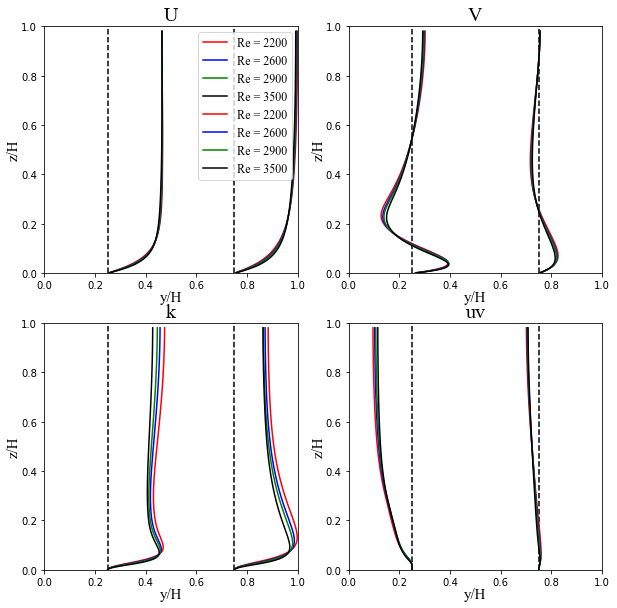

In [23]:
Ubulk = 0.482
rho = 1
H = 1
Re = 2200
mu = rho*Ubulk*H/Re
nu = mu/rho
fig = plt.figure(figsize=(10.0,10.0))
csfont = {'fontname':'Times New Roman'}
font = font_manager.FontProperties(family='Times New Roman', style='normal', size=12)

scaleU = 0.2
scaleV = 7
scalek = 25
scaleuv = 70
scaleuw = 10

################## U
ax = fig.add_subplot(2,2,1)
plt.title('U', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2200RSM.shape[0])
ax.plot(scaleU*U2200RSM[:id]/Ubulk+0.25, zH2200RSM[:id],'red', label = 'Re = 2200', linestyle="-")
ax.plot(scaleU*U2600RSM[:id]/Ubulk+0.25, zH2200RSM[:id],'blue', label = 'Re = 2600', linestyle="-")
ax.plot(scaleU*U2900RSM[:id]/Ubulk+0.25, zH2200DNS[:id],'green', label = 'Re = 2900', linestyle="-")
ax.plot(scaleU*U3500RSM[:id]/Ubulk+0.25, zH2200DNS[:id],'black', label = 'Re = 3500', linestyle="-")
ax.plot(scaleU*U2200RSM[id:2*id]/Ubulk+0.75, zH2200RSM[:id],'red', label = 'Re = 2200', linestyle="-")
ax.plot(scaleU*U2600RSM[id:2*id]/Ubulk+0.75, zH2200RSM[:id],'blue', label = 'Re = 2600', linestyle="-")
ax.plot(scaleU*U2900RSM[id:2*id]/Ubulk+0.75, zH2200DNS[:id],'green', label = 'Re = 2900', linestyle="-")
ax.plot(scaleU*U3500RSM[id:2*id]/Ubulk+0.75, zH2200DNS[:id],'black', label = 'Re = 3500', linestyle="-")
ax.set_xlabel('y/H', fontsize=15, labelpad=0,**csfont)
ax.set_ylabel('z/H', rotation=90, fontsize=15, labelpad=0,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

################## V
ax = fig.add_subplot(2,2,2)
plt.title('V', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2200RSM.shape[0])
ax.plot(scaleV*V2200RSM[:id]/Ubulk+0.25, zH2200RSM[:id],'red', label = 'Re = 2200', linestyle="-")
ax.plot(scaleV*V2600RSM[:id]/Ubulk+0.25, zH2200RSM[:id],'blue', label = 'Re = 2600', linestyle="-")
ax.plot(scaleV*V2900RSM[:id]/Ubulk+0.25, zH2200DNS[:id],'green', label = 'Re = 2900', linestyle="-")
ax.plot(scaleV*V3500RSM[:id]/Ubulk+0.25, zH2200DNS[:id],'black', label = 'Re = 3500', linestyle="-")
ax.plot(scaleV*V2200RSM[id:2*id]/Ubulk+0.75, zH2200RSM[:id],'red', label = 'Re = 2200', linestyle="-")
ax.plot(scaleV*V2600RSM[id:2*id]/Ubulk+0.75, zH2200RSM[:id],'blue', label = 'Re = 2600', linestyle="-")
ax.plot(scaleV*V2900RSM[id:2*id]/Ubulk+0.75, zH2200DNS[:id],'green', label = 'Re = 2900', linestyle="-")
ax.plot(scaleV*V3500RSM[id:2*id]/Ubulk+0.75, zH2200DNS[:id],'black', label = 'Re = 3500', linestyle="-")
ax.set_xlabel('y/H', fontsize=15, labelpad=0,**csfont)
ax.set_ylabel('z/H', rotation=90, fontsize=15, labelpad=0,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
#plt.legend(loc=(0.5, 0.6))
#plt.legend(prop=font)

################## k
ax = fig.add_subplot(2,2,3)
plt.title('k', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2200RSM.shape[0])
ax.plot(scalek*k2200RSM[:id]/Ubulk+0.25, zH2200RSM[:id],'red', label = 'Re = 2200', linestyle="-")
ax.plot(scalek*k2600RSM[:id]/Ubulk+0.25, zH2200RSM[:id],'blue', label = 'Re = 2600', linestyle="-")
ax.plot(scalek*k2900RSM[:id]/Ubulk+0.25, zH2200DNS[:id],'green', label = 'Re = 2900', linestyle="-")
ax.plot(scalek*k3500RSM[:id]/Ubulk+0.25, zH2200DNS[:id],'black', label = 'Re = 3500', linestyle="-")
ax.plot(scalek*k2200RSM[id:2*id]/Ubulk+0.75, zH2200RSM[:id],'red', label = 'Re = 2200', linestyle="-")
ax.plot(scalek*k2600RSM[id:2*id]/Ubulk+0.75, zH2200RSM[:id],'blue', label = 'Re = 2600', linestyle="-")
ax.plot(scalek*k2900RSM[id:2*id]/Ubulk+0.75, zH2200DNS[:id],'green', label = 'Re = 2900', linestyle="-")
ax.plot(scalek*k3500RSM[id:2*id]/Ubulk+0.75, zH2200DNS[:id],'black', label = 'Re = 3500', linestyle="-")
ax.set_xlabel('y/H', fontsize=15, labelpad=0,**csfont)
ax.set_ylabel('z/H', rotation=90, fontsize=15, labelpad=0,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
#plt.legend(loc=(0.5, 0.6))
#plt.legend(prop=font)


################## uv
ax = fig.add_subplot(2,2,4)
plt.title('uv', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2200RSM.shape[0])
ax.plot(scaleuv*uv2200RSM[:id]/Ubulk+0.25, zH2200RSM[:id],'red', label = 'Re = 2200', linestyle="-")
ax.plot(scaleuv*uv2600RSM[:id]/Ubulk+0.25, zH2200RSM[:id],'blue', label = 'Re = 2600', linestyle="-")
ax.plot(scaleuv*uv2900RSM[:id]/Ubulk+0.25, zH2200DNS[:id],'green', label = 'Re = 2900', linestyle="-")
ax.plot(scaleuv*uv3500RSM[:id]/Ubulk+0.25, zH2200DNS[:id],'black', label = 'Re = 3500', linestyle="-")
ax.plot(scaleuv*uv2200RSM[id:2*id]/Ubulk+0.75, zH2200RSM[:id],'red', label = 'Re = 2200', linestyle="-")
ax.plot(scaleuv*uv2600RSM[id:2*id]/Ubulk+0.75, zH2200RSM[:id],'blue', label = 'Re = 2600', linestyle="-")
ax.plot(scaleuv*uv2900RSM[id:2*id]/Ubulk+0.75, zH2200DNS[:id],'green', label = 'Re = 2900', linestyle="-")
ax.plot(scaleuv*uv3500RSM[id:2*id]/Ubulk+0.75, zH2200DNS[:id],'black', label = 'Re = 3500', linestyle="-")
ax.set_xlabel('y/H', fontsize=15, labelpad=0,**csfont)
ax.set_ylabel('z/H', rotation=90, fontsize=15, labelpad=0,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
#plt.legend(loc=(0.5, 0.6))
#plt.legend(prop=font)

## DNS-RSM comparison: Velocity and Reynolds stress

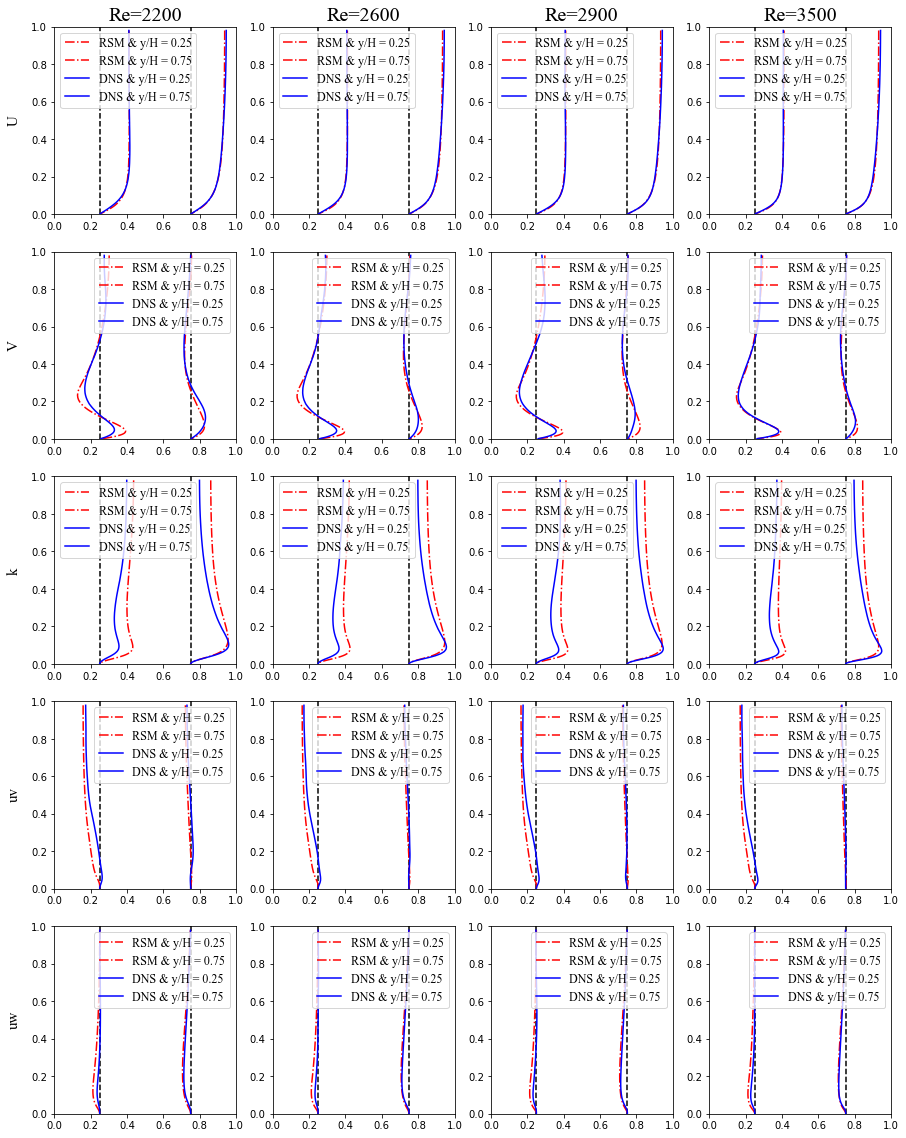

In [16]:
Ubulk = 0.482
rho = 1
H = 1
Re = 2200
mu = rho*Ubulk*H/Re
nu = mu/rho
fig = plt.figure(figsize=(15.0,20.0))
csfont = {'fontname':'Times New Roman'}
font = font_manager.FontProperties(family='Times New Roman', style='normal', size=12)

scaleU = 0.15
scaleV = 7
scalek = 10
scaleuv = 20
scaleuw = 10

################## U

ax = fig.add_subplot(5,4,1)
plt.title('Re=2200', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2200RSM.shape[0])
jd = int(0.5*zH2200DNS.shape[0])
ax.plot(scaleU*U2200RSM[:id]/Ubulk+0.25, zH2200RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleU*U2200RSM[id:2*id]/Ubulk+0.75, zH2200RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleU*U2200DNS[:jd]/Ubulk+0.25, zH2200DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleU*U2200DNS[jd:2*jd]/Ubulk+0.75, zH2200DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_xlabel('Re = 2200', fontsize=15, labelpad=10,**csfont)
ax.set_ylabel('U', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,2)
plt.title('Re=2600', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2600RSM.shape[0])
jd = int(0.5*zH2600DNS.shape[0])
ax.plot(scaleU*U2600RSM[:id]/Ubulk+0.25, zH2600RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleU*U2600RSM[id:2*id]/Ubulk+0.75, zH2600RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleU*U2600DNS[:jd]/Ubulk+0.25, zH2600DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleU*U2600DNS[jd:2*jd]/Ubulk+0.75, zH2600DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_xlabel('Re = 2600', fontsize=15, labelpad=10,**csfont)
#ax.set_ylabel('Re = 2600', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,3)
plt.title('Re=2900', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2900RSM.shape[0])
jd = int(0.5*zH2900DNS.shape[0])
ax.plot(scaleU*U2900RSM[:id]/Ubulk+0.25, zH2900RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleU*U2900RSM[id:2*id]/Ubulk+0.75, zH2900RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleU*U2900DNS[:jd]/Ubulk+0.25, zH2900DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleU*U2900DNS[jd:2*jd]/Ubulk+0.75, zH2900DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_xlabel('Re = 2900', fontsize=15, labelpad=10,**csfont)
#ax.set_ylabel('Re = 2900', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,4)
plt.title('Re=3500', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH3500RSM.shape[0])
jd = int(0.5*zH3500DNS.shape[0])
ax.plot(scaleU*U3500RSM[:id]/Ubulk+0.25, zH3500RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleU*U3500RSM[id:2*id]/Ubulk+0.75, zH3500RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleU*U3500DNS[:jd]/Ubulk+0.25, zH3500DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleU*U3500DNS[jd:2*jd]/Ubulk+0.75, zH3500DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_xlabel('Re = 3500', fontsize=15, labelpad=10,**csfont)
#ax.set_ylabel('Re = 3500', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)


################## V
ax = fig.add_subplot(5,4,5)
#plt.title('Re=2200', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2200RSM.shape[0])
jd = int(0.5*zH2200DNS.shape[0])
ax.plot(scaleV*V2200RSM[:id]/Ubulk+0.25, zH2200RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleV*V2200RSM[id:2*id]/Ubulk+0.75, zH2200RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleV*V2200DNS[:jd]/Ubulk+0.25, zH2200DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleV*V2200DNS[jd:2*jd]/Ubulk+0.75, zH2200DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_xlabel('Re = 2200', fontsize=15, labelpad=10,**csfont)
ax.set_ylabel('V', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,6)
#plt.title('Re=2600', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2600RSM.shape[0])
jd = int(0.5*zH2600DNS.shape[0])
ax.plot(scaleV*V2600RSM[:id]/Ubulk+0.25, zH2600RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleV*V2600RSM[id:2*id]/Ubulk+0.75, zH2600RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleV*V2600DNS[:jd]/Ubulk+0.25, zH2600DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleV*V2600DNS[jd:2*jd]/Ubulk+0.75, zH2600DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_xlabel('Re = 2600', fontsize=15, labelpad=10,**csfont)
#ax.set_ylabel('Re = 2600', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,7)
#plt.title('Re=2900', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2900RSM.shape[0])
jd = int(0.5*zH2900DNS.shape[0])
ax.plot(scaleV*V2900RSM[:id]/Ubulk+0.25, zH2900RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleV*V2900RSM[id:2*id]/Ubulk+0.75, zH2900RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleV*V2900DNS[:jd]/Ubulk+0.25, zH2900DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleV*V2900DNS[jd:2*jd]/Ubulk+0.75, zH2900DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_xlabel('Re = 2900', fontsize=15, labelpad=10,**csfont)
#ax.set_ylabel('Re = 2900', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,8)
#plt.title('Re=3500', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH3500RSM.shape[0])
jd = int(0.5*zH3500DNS.shape[0])
ax.plot(scaleV*V3500RSM[:id]/Ubulk+0.25, zH3500RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleV*V3500RSM[id:2*id]/Ubulk+0.75, zH3500RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleV*V3500DNS[:jd]/Ubulk+0.25, zH3500DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleV*V3500DNS[jd:2*jd]/Ubulk+0.75, zH3500DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_xlabel('Re = 3500', fontsize=15, labelpad=10,**csfont)
#ax.set_ylabel('Re = 3500', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)


################## k

ax = fig.add_subplot(5,4,9)
#plt.title('k', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2200RSM.shape[0])
jd = int(0.5*zH2200DNS.shape[0])
ax.plot(scalek*k2200RSM[:id]/pow(Ubulk,2)+0.25, zH2200RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scalek*k2200RSM[id:2*id]/pow(Ubulk,2)+0.75, zH2200RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scalek*k2200DNS[:jd]/pow(Ubulk,2)+0.25, zH2200DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scalek*k2200DNS[jd:2*jd]/pow(Ubulk,2)+0.75, zH2200DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
ax.set_ylabel('k', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,10)
#plt.title('k', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2600RSM.shape[0])
jd = int(0.5*zH2600DNS.shape[0])
ax.plot(scalek*k2600RSM[:id]/pow(Ubulk,2)+0.25, zH2600RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scalek*k2600RSM[id:2*id]/pow(Ubulk,2)+0.75, zH2600RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scalek*k2600DNS[:jd]/pow(Ubulk,2)+0.25, zH2600DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scalek*k2600DNS[jd:2*jd]/pow(Ubulk,2)+0.75, zH2600DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_ylabel('Re = 2600', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,11)
#plt.title('k', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2900RSM.shape[0])
jd = int(0.5*zH2900DNS.shape[0])
ax.plot(scalek*k2900RSM[:id]/pow(Ubulk,2)+0.25, zH2900RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scalek*k2900RSM[id:2*id]/pow(Ubulk,2)+0.75, zH2900RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scalek*k2900DNS[:jd]/pow(Ubulk,2)+0.25, zH2900DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scalek*k2900DNS[jd:2*jd]/pow(Ubulk,2)+0.75, zH2900DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_ylabel('Re = 2900', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,12)
#plt.title('k', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH3500RSM.shape[0])
jd = int(0.5*zH3500DNS.shape[0])
ax.plot(scalek*k3500RSM[:id]/pow(Ubulk,2)+0.25, zH3500RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scalek*k3500RSM[id:2*id]/pow(Ubulk,2)+0.75, zH3500RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scalek*k3500DNS[:jd]/pow(Ubulk,2)+0.25, zH3500DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scalek*k3500DNS[jd:2*jd]/pow(Ubulk,2)+0.75, zH3500DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_ylabel('Re = 3500', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

################## uv

ax = fig.add_subplot(5,4,13)
#plt.title('uv', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2200RSM.shape[0])
jd = int(0.5*zH2200DNS.shape[0])
ax.plot(scaleuv*uv2200RSM[:id]/pow(Ubulk,2)+0.25, zH2200RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleuv*uv2200RSM[id:2*id]/pow(Ubulk,2)+0.75, zH2200RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleuv*uv2200DNS[:jd]/pow(Ubulk,2)+0.25, zH2200DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleuv*uv2200DNS[jd:2*jd]/pow(Ubulk,2)+0.75, zH2200DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
ax.set_ylabel('uv', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,14)
#plt.title('uv', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2600RSM.shape[0])
jd = int(0.5*zH2600DNS.shape[0])
ax.plot(scaleuv*uv2600RSM[:id]/pow(Ubulk,2)+0.25, zH2600RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleuv*uv2600RSM[id:2*id]/pow(Ubulk,2)+0.75, zH2600RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleuv*uv2600DNS[:jd]/pow(Ubulk,2)+0.25, zH2600DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleuv*uv2600DNS[jd:2*jd]/pow(Ubulk,2)+0.75, zH2600DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_ylabel('Re = 2600', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,15)
#plt.title('uv', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2900RSM.shape[0])
jd = int(0.5*zH2900DNS.shape[0])
ax.plot(scaleuv*uv2900RSM[:id]/pow(Ubulk,2)+0.25, zH2900RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleuv*uv2900RSM[id:2*id]/pow(Ubulk,2)+0.75, zH2900RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleuv*uv2900DNS[:jd]/pow(Ubulk,2)+0.25, zH2900DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleuv*uv2900DNS[jd:2*jd]/pow(Ubulk,2)+0.75, zH2900DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_ylabel('Re = 2900', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,16)
#plt.title('uv', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH3500RSM.shape[0])
jd = int(0.5*zH3500DNS.shape[0])
ax.plot(scaleuv*uv3500RSM[:id]/pow(Ubulk,2)+0.25, zH3500RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleuv*uv3500RSM[id:2*id]/pow(Ubulk,2)+0.75, zH3500RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleuv*uv3500DNS[:jd]/pow(Ubulk,2)+0.25, zH3500DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleuv*uv3500DNS[jd:2*jd]/pow(Ubulk,2)+0.75, zH3500DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_ylabel('Re = 3500', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

################## uw

ax = fig.add_subplot(5,4,17)
#plt.title('uw', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2200RSM.shape[0])
jd = int(0.5*zH2200DNS.shape[0])
ax.plot(scaleuw*uw2200RSM[:id]/pow(Ubulk,2)+0.25, zH2200RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleuw*uw2200RSM[id:2*id]/pow(Ubulk,2)+0.75, zH2200RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleuw*uw2200DNS[:jd]/pow(Ubulk,2)+0.25, zH2200DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleuw*uw2200DNS[jd:2*jd]/pow(Ubulk,2)+0.75, zH2200DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
ax.set_ylabel('uw', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,18)
#plt.title('uw', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2600RSM.shape[0])
jd = int(0.5*zH2600DNS.shape[0])
ax.plot(scaleuw*uw2600RSM[:id]/pow(Ubulk,2)+0.25, zH2600RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleuw*uw2600RSM[id:2*id]/pow(Ubulk,2)+0.75, zH2600RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleuw*uw2600DNS[:jd]/pow(Ubulk,2)+0.25, zH2600DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleuw*uw2600DNS[jd:2*jd]/pow(Ubulk,2)+0.75, zH2600DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_ylabel('Re = 2600', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,19)
#plt.title('uw', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH2900RSM.shape[0])
jd = int(0.5*zH2900DNS.shape[0])
ax.plot(scaleuw*uw2900RSM[:id]/pow(Ubulk,2)+0.25, zH2900RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleuw*uw2900RSM[id:2*id]/pow(Ubulk,2)+0.75, zH2900RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleuw*uw2900DNS[:jd]/pow(Ubulk,2)+0.25, zH2900DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleuw*uw2900DNS[jd:2*jd]/pow(Ubulk,2)+0.75, zH2900DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_ylabel('Re = 2900', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(5,4,20)
#plt.title('uw', fontsize=20,**csfont)
ax.plot([0.25, 0.25], [0, 1], color='black',linestyle="--")
ax.plot([0.75, 0.75], [0, 1], color='black',linestyle="--")
id = int(0.5*zH3500RSM.shape[0])
jd = int(0.5*zH3500DNS.shape[0])
ax.plot(scaleuw*uw3500RSM[:id]/pow(Ubulk,2)+0.25, zH3500RSM[:id],'red', label = 'RSM & y/H = 0.25', linestyle="-.")
ax.plot(scaleuw*uw3500RSM[id:2*id]/pow(Ubulk,2)+0.75, zH3500RSM[id:2*id],'red', label = 'RSM & y/H = 0.75', linestyle="-.")
ax.plot(scaleuw*uw3500DNS[:jd]/pow(Ubulk,2)+0.25, zH3500DNS[:jd],'blue', label = 'DNS & y/H = 0.25', linestyle="-")
ax.plot(scaleuw*uw3500DNS[jd:2*jd]/pow(Ubulk,2)+0.75, zH3500DNS[jd:2*jd],'blue', label = 'DNS & y/H = 0.75', linestyle="-")
#ax.set_ylabel('Re = 3500', rotation=90, fontsize=15, labelpad=10,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)


## DNS-RSM comparison: Barycentric triangle and Euler angles

In [41]:
filename = 'C:/Users /Desktop/SquareDuct_database/ML-RSM-DNS comparison results/line results/RSM_line_Bary'
raw_data = open(filename, 'rb')
data = np.loadtxt(raw_data, delimiter=',', skiprows=1)
log10turbk_line_RSM = data[:,0]
zetta_line_RSM = data[:,1]
etta_line_RSM = data[:,2]
Phi1_line_RSM = data[:,3]
Phi2_line_RSM = data[:,4]
Phi3_line_RSM = data[:,5]

filename = 'C:/Users /Desktop/SquareDuct_database/ML-RSM-DNS comparison results/line results/PDNS_line_Bary'
raw_data = open(filename, 'rb')
data = np.loadtxt(raw_data, delimiter=',', skiprows=1)
log10turbk_line_DNS = data[:,0]
zetta_line_DNS = data[:,1]
etta_line_DNS = data[:,2]
Phi1_line_DNS = data[:,3]
Phi2_line_DNS = data[:,4]
Phi3_line_DNS = data[:,5]


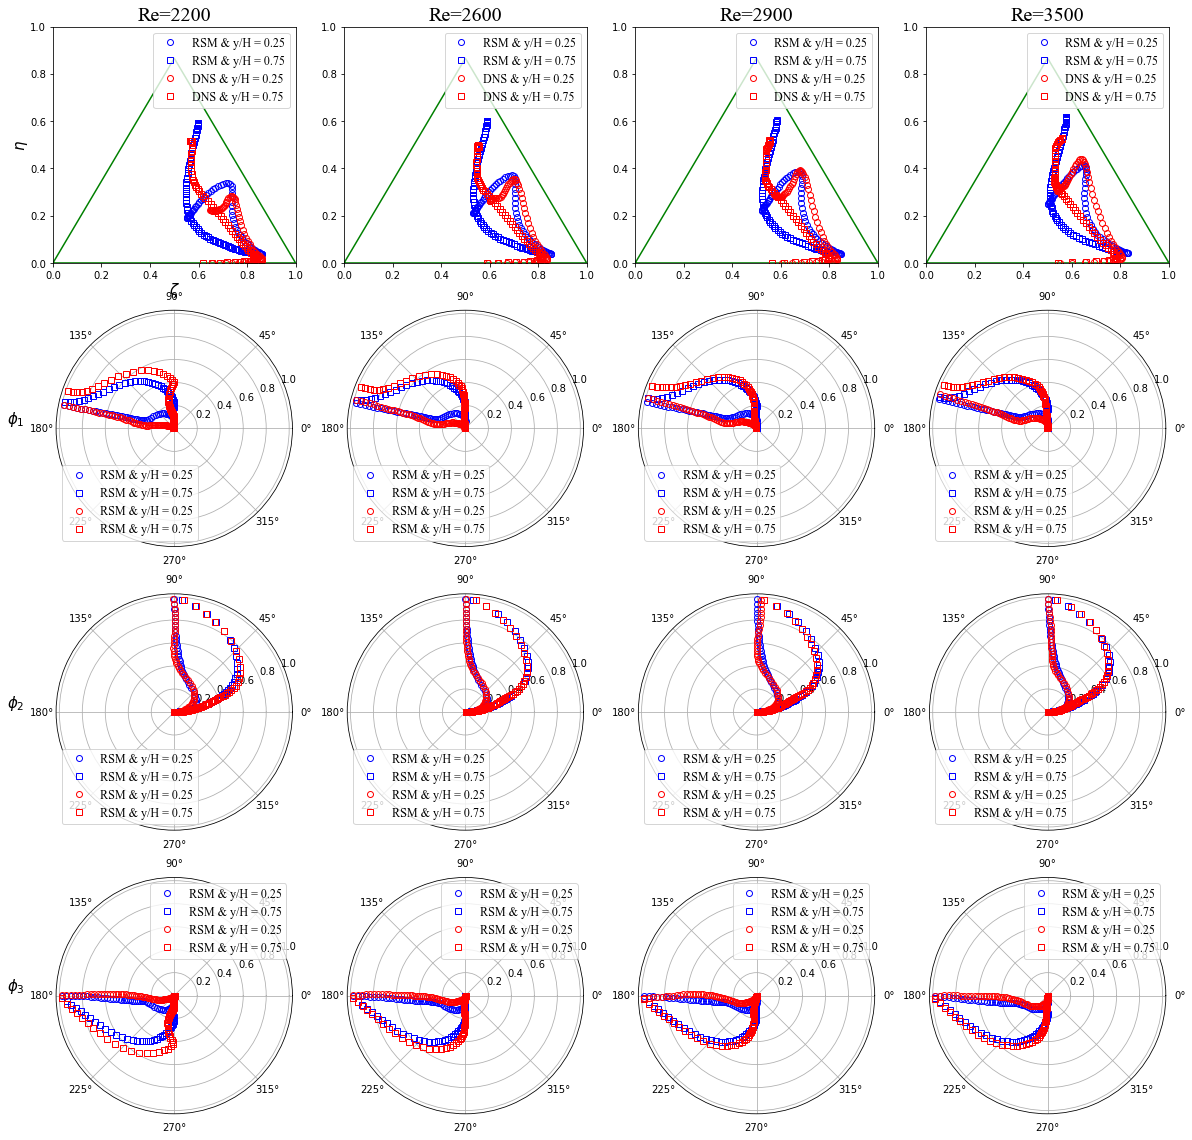

In [113]:
fig = plt.figure(figsize=(20.0,20.0))
csfont = {'fontname':'Times New Roman'}
font = font_manager.FontProperties(family='Times New Roman', style='normal', size=12)

################## zetta-etta

ax = fig.add_subplot(4,4,1)
plt.title('Re=2200', fontsize=20,**csfont)
ax.plot([0,1,0.5,0.5,0],[0,0,3**0.5/2.0,3**0.5/2.0,0],'g-')
id = int(0.5*zH2200RSM.shape[0])
jd = int(0.5*zH2200DNS.shape[0])
ax.plot(zetta_line_RSM[:id], etta_line_RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
ax.set_ylabel('$\eta$', rotation=90, fontsize=15, labelpad=0,**csfont)
ax.set_xlabel('$\zeta$', fontsize=15, labelpad=0,**csfont)
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(4,4,2)
plt.title('Re=2600', fontsize=20,**csfont)
ax.plot([0,1,0.5,0.5,0],[0,0,3**0.5/2.0,3**0.5/2.0,0],'g-')
id = int(0.5*zH2600RSM.shape[0])
jd = int(0.5*zH2600DNS.shape[0])
ax.plot(zetta_line_RSM[2*id:3*id], etta_line_RSM[2*id:3*id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot(zetta_line_RSM[3*id:4*id], etta_line_RSM[3*id:4*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot(zetta_line_DNS[2*jd:3*jd], etta_line_DNS[2*jd:3*jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
ax.plot(zetta_line_DNS[3*jd:4*jd], etta_line_DNS[3*jd:4*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(4,4,3)
plt.title('Re=2900', fontsize=20,**csfont)
ax.plot([0,1,0.5,0.5,0],[0,0,3**0.5/2.0,3**0.5/2.0,0],'g-')
id = int(0.5*zH2900RSM.shape[0])
jd = int(0.5*zH2900DNS.shape[0])
ax.plot(zetta_line_RSM[4*id:5*id], etta_line_RSM[4*id:5*id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot(zetta_line_RSM[5*id:6*id], etta_line_RSM[5*id:6*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot(zetta_line_DNS[4*jd:5*jd], etta_line_DNS[4*jd:5*jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
ax.plot(zetta_line_DNS[5*jd:6*jd], etta_line_DNS[5*jd:6*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(4,4,4)
plt.title('Re=3500', fontsize=20,**csfont)
ax.plot([0,1,0.5,0.5,0],[0,0,3**0.5/2.0,3**0.5/2.0,0],'g-')
id = int(0.5*zH3500RSM.shape[0])
jd = int(0.5*zH3500DNS.shape[0])
ax.plot(zetta_line_RSM[6*id:7*id], etta_line_RSM[6*id:7*id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot(zetta_line_RSM[7*id:8*id], etta_line_RSM[7*id:8*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot(zetta_line_DNS[6*jd:7*jd], etta_line_DNS[6*jd:7*jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
ax.plot(zetta_line_DNS[7*jd:8*jd], etta_line_DNS[7*jd:8*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
ax.set_xlim(0, 1.0)
ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

################## z/H-Phi1

ax = fig.add_subplot(4,4,5, polar=True)
#plt.title('Re=2200', fontsize=20,**csfont)
id = int(0.5*zH2200RSM.shape[0])
jd = int(0.5*zH2200DNS.shape[0])
ax.plot( Phi1_line_RSM[:id], zH2200RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot( Phi1_line_RSM[id:2*id], zH2200RSM[:id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot( Phi1_line_DNS[:jd], zH2200RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.25')
ax.plot( Phi1_line_DNS[jd:2*jd], zH2200DNS[:jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.75')
ax.set_ylabel('$\phi_{1}$', rotation=0, fontsize=15, labelpad=40,**csfont)
#ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
#ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
#ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
#ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(4,4,6, polar=True)
#plt.title('Re=2600', fontsize=20,**csfont)
id = int(0.5*zH2600RSM.shape[0])
jd = int(0.5*zH2600DNS.shape[0])
ax.plot( Phi1_line_RSM[2*id:3*id], zH2600RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot( Phi1_line_RSM[3*id:4*id], zH2600RSM[:id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot( Phi1_line_DNS[2*jd:3*jd], zH2600RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.25')
ax.plot( Phi1_line_DNS[3*jd:4*jd], zH2600DNS[:jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.75')
#ax.set_ylabel('$\phi_{1}$', rotation=0, fontsize=15, labelpad=40,**csfont)
#ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
#ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
#ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
#ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(4,4,7, polar=True)
#plt.title('Re=2900', fontsize=20,**csfont)
id = int(0.5*zH2900RSM.shape[0])
jd = int(0.5*zH2900DNS.shape[0])
ax.plot( Phi1_line_RSM[4*id:5*id], zH2900RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot( Phi1_line_RSM[5*id:6*id], zH2900RSM[:id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot( Phi1_line_DNS[4*jd:5*jd], zH2900RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.25')
ax.plot( Phi1_line_DNS[5*jd:6*jd], zH2900DNS[:jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.75')
#ax.set_ylabel('$\phi_{1}$', rotation=0, fontsize=15, labelpad=40,**csfont)
#ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
#ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
#ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
#ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(4,4,8, polar=True)
#plt.title('Re=3500', fontsize=20,**csfont)
id = int(0.5*zH2900RSM.shape[0])
jd = int(0.5*zH2900DNS.shape[0])
ax.plot( Phi1_line_RSM[6*id:7*id], zH3500RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot( Phi1_line_RSM[7*id:8*id], zH3500RSM[:id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot( Phi1_line_DNS[6*jd:7*jd], zH3500RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.25')
ax.plot( Phi1_line_DNS[7*jd:8*jd], zH3500DNS[:jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.75')
#ax.set_ylabel('$\phi_{1}$', rotation=0, fontsize=15, labelpad=40,**csfont)
#ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
#ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
#ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
#ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)
################## z/H-Phi2

ax = fig.add_subplot(4,4,9, polar=True)
#plt.title('Re=2200', fontsize=20,**csfont)

id = int(0.5*zH2200RSM.shape[0])
jd = int(0.5*zH2200DNS.shape[0])
ax.plot( Phi2_line_RSM[:id], zH2200RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot( Phi2_line_RSM[id:2*id], zH2200RSM[:id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot( Phi2_line_DNS[:jd], zH2200RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.25')
ax.plot( Phi2_line_DNS[jd:2*jd], zH2200DNS[:jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.75')
ax.set_ylabel('$\phi_{2}$', rotation=0, fontsize=15, labelpad=40,**csfont)
#ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
#ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
#ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
#ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(4,4,10, polar=True)
#plt.title('Re=2600', fontsize=20,**csfont)
id = int(0.5*zH2600RSM.shape[0])
jd = int(0.5*zH2600DNS.shape[0])
ax.plot( Phi2_line_RSM[2*id:3*id], zH2600RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot( Phi2_line_RSM[3*id:4*id], zH2600RSM[:id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot( Phi2_line_DNS[2*jd:3*jd], zH2600RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.25')
ax.plot( Phi2_line_DNS[3*jd:4*jd], zH2600DNS[:jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.75')
#ax.set_ylabel('$\phi_{1}$', rotation=0, fontsize=15, labelpad=40,**csfont)
#ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
#ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
#ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
#ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(4,4,11, polar=True)
#plt.title('Re=2900', fontsize=20,**csfont)
id = int(0.5*zH2900RSM.shape[0])
jd = int(0.5*zH2900DNS.shape[0])
ax.plot( Phi2_line_RSM[4*id:5*id], zH2900RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot( Phi2_line_RSM[5*id:6*id], zH2900RSM[:id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot( Phi2_line_DNS[4*jd:5*jd], zH2900RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.25')
ax.plot( Phi2_line_DNS[5*jd:6*jd], zH2900DNS[:jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.75')
#ax.set_ylabel('$\phi_{1}$', rotation=0, fontsize=15, labelpad=40,**csfont)
#ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
#ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
#ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
#ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(4,4,12, polar=True)
#plt.title('Re=3500', fontsize=20,**csfont)
id = int(0.5*zH3500RSM.shape[0])
jd = int(0.5*zH3500DNS.shape[0])
ax.plot( Phi2_line_RSM[6*id:7*id], zH3500RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot( Phi2_line_RSM[7*id:8*id], zH3500RSM[:id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot( Phi2_line_DNS[6*jd:7*jd], zH3500RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.25')
ax.plot( Phi2_line_DNS[7*jd:8*jd], zH3500DNS[:jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.75')
#ax.set_ylabel('$\phi_{1}$', rotation=0, fontsize=15, labelpad=40,**csfont)
#ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
#ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
#ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
#ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

################## z/H-Phi3

ax = fig.add_subplot(4,4,13, polar=True)
#plt.title('Re=2200', fontsize=20,**csfont)

id = int(0.5*zH2200RSM.shape[0])
jd = int(0.5*zH2200DNS.shape[0])
ax.plot( Phi3_line_RSM[:id], zH2200RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot( Phi3_line_RSM[id:2*id], zH2200RSM[:id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot( Phi3_line_DNS[:jd], zH2200RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.25')
ax.plot( Phi3_line_DNS[jd:2*jd], zH2200DNS[:jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.75')
ax.set_ylabel('$\phi_{3}$', rotation=0, fontsize=15, labelpad=40,**csfont)
#ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
#ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
#ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
#ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(4,4,14, polar=True)
#plt.title('Re=2600', fontsize=20,**csfont)
id = int(0.5*zH2600RSM.shape[0])
jd = int(0.5*zH2600DNS.shape[0])
ax.plot( Phi3_line_RSM[2*id:3*id], zH2600RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot( Phi3_line_RSM[3*id:4*id], zH2600RSM[:id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot( Phi3_line_DNS[2*jd:3*jd], zH2600RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.25')
ax.plot( Phi3_line_DNS[3*jd:4*jd], zH2600DNS[:jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.75')
#ax.set_ylabel('$\phi_{1}$', rotation=0, fontsize=15, labelpad=40,**csfont)
#ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
#ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
#ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
#ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(4,4,15, polar=True)
#plt.title('Re=2900', fontsize=20,**csfont)
id = int(0.5*zH2900RSM.shape[0])
jd = int(0.5*zH2900DNS.shape[0])
ax.plot( Phi3_line_RSM[4*id:5*id], zH2900RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot( Phi3_line_RSM[5*id:6*id], zH2900RSM[:id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot( Phi3_line_DNS[4*jd:5*jd], zH2900RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.25')
ax.plot( Phi3_line_DNS[5*jd:6*jd], zH2900DNS[:jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.75')
#ax.set_ylabel('$\phi_{1}$', rotation=0, fontsize=15, labelpad=40,**csfont)
#ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
#ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
#ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
#ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

ax = fig.add_subplot(4,4,16, polar=True)
#plt.title('Re=3500', fontsize=20,**csfont)
id = int(0.5*zH3500RSM.shape[0])
jd = int(0.5*zH3500DNS.shape[0])
ax.plot( Phi3_line_RSM[6*id:7*id], zH3500RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.25')
ax.plot( Phi3_line_RSM[7*id:8*id], zH3500RSM[:id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
ax.plot( Phi3_line_DNS[6*jd:7*jd], zH3500RSM[:id], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.25')
ax.plot( Phi3_line_DNS[7*jd:8*jd], zH3500DNS[:jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'RSM & y/H = 0.75')
#ax.set_ylabel('$\phi_{1}$', rotation=0, fontsize=15, labelpad=40,**csfont)
#ax.plot(zetta_line_RSM[id:2*id], etta_line_RSM[id:2*id], 'ks', markerfacecolor='none', markeredgecolor='b', label = 'RSM & y/H = 0.75')
#ax.plot(zetta_line_DNS[:jd], etta_line_DNS[:jd], 'bo', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.25')
#ax.plot(zetta_line_DNS[jd:2*jd], etta_line_DNS[jd:2*jd], 'ks', markerfacecolor='none', markeredgecolor='r', label = 'DNS & y/H = 0.75')
#ax.set_xlim(0, 1.0)
#ax.set_ylim(0, 1.0)
plt.legend(loc=(0.5, 0.6))
plt.legend(prop=font)

# Barycentric triangle, DNS-RSM comparison

In this section, a comparison between the status of turbulence anisotropy of DNS and RSM results is presented. 
<b>Note: If your Trust Notebook is not active please asctivate it as:</b> Open Notebook in Jupyter -> Click File -> Trust Notebook

In [7]:
from sklearn.ensemble._forest import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import time

In [8]:
filename = 'C:/Users /Desktop/SquareDuct_database/ML-RSM-DNS comparison results/plane results/FeaturesDiscrepancies of TrainandValidation data.txt'
raw_data = open(filename, 'rb')
data = np.loadtxt(raw_data)
id = int(data.shape[0]/4)
yHtrain = data[0:3*id,0:1]
zHtrain = data[0:3*id,1:2]
trainReyNum = data[0:3*id,2:3]

trainFeatures = data[0:3*id,3:13]
trainResponses = data[0:3*id,13:19]

yHtest = data[3*id:,0:1]
zHtest = data[3*id:,1:2]
testReyNum = data[3*id:,2:3]

testFeatures = data[3*id:,3:13]
testResponses = data[3*id:,13:19]

# train features and test features dataset visualization

NameError: name 'yHtrain' is not defined

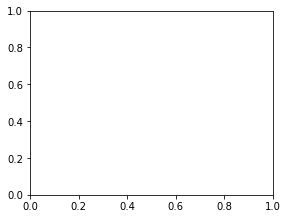

In [5]:
# train features and test features dataset visualization

import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np

fig = plt.figure(figsize=(20.0,40.0))
csfont = {'fontname':'Times New Roman'}

###################### Discrepancies on K: Log10(K_DNS)-Log10(K_RSM)
levelsk = np.linspace(-3.5, 0, 10)
ax1 = fig.add_subplot(10,4,1)    
contour1 = ax1.tricontourf(yHtrain[0:id,0],zHtrain[0:id,0],trainResponses[0:id,0],256,cmap=plt.cm.jet,levels=levelsk)
ax1.set_aspect('equal')
ax1.set_ylabel('Q$_{1}$', rotation=90, fontsize=15, labelpad=10,**csfont)
cbar = plt.colorbar(contour1, fraction=0.046, pad=0.04)
plt.title('Re = 2200', fontsize=20,**csfont)

ax2 = fig.add_subplot(10,4,2) 
contour2 = ax2.tricontourf(yHtrain[id:2*id,0],zHtrain[id:2*id,0],trainResponses[id:2*id,0],256,cmap=plt.cm.jet,levels=levelsk)
ax2.set_aspect('equal')
cbar = plt.colorbar(contour2, fraction=0.046, pad=0.04)
plt.title('Re = 2600', fontsize=20,**csfont)

ax3 = fig.add_subplot(10,4,3) 
contour3 = ax3.tricontourf(yHtrain[2*id:3*id,0],zHtrain[2*id:3*id,0],trainResponses[2*id:3*id,0],256,cmap=plt.cm.jet,levels=levelsk)
ax3.set_aspect('equal')
cbar = plt.colorbar(contour3, fraction=0.046, pad=0.04)
plt.title('Re = 2900', fontsize=20,**csfont)

ax4 = fig.add_subplot(10,4,4) 
contour4 = ax4.tricontourf(yHtest[0:id,0],zHtest[0:id,0],testResponses[0:id,0],256,cmap=plt.cm.jet,levels=levelsk)
ax4.set_aspect('equal')
cbar = plt.colorbar(contour4, fraction=0.046, pad=0.04)
plt.title('Re = 3500', fontsize=20,**csfont)



for i in range(1,10):
    j = 4*i + 1
    if i == 1:
        levels = np.linspace(0,1,10)
    elif i == 2:
        levels = np.linspace(-1,2.1,10)
    elif i == 3:
        levels = np.linspace(-0.5,0.5,10)
    elif i == 4:
        levels = np.linspace(0,0.6,10)
    elif i == 5:
        levels = np.linspace(0.95,1,10) 
    elif i == 6:
        levels = np.linspace(-0.1,1,10)
    elif i == 7:
        levels = np.linspace(-1,1,10) 
    elif i == 8:
        levels = np.linspace(0,1.5,10)
    elif i == 9:
        levels = np.linspace(-0.2,0.1,10)
        
        
    ax = fig.add_subplot(10,4,j)    
    contour = ax.tricontourf(yHtrain[0:id,0],zHtrain[0:id,0],trainFeatures[0:id,i],256,cmap=plt.cm.jet,levels=levels)
    ax.set_aspect('equal')
    ax.set_ylabel('$Q_{'+str(i+1)+'}$', rotation=90, fontsize=15, labelpad=10,**csfont)
    cbar = plt.colorbar(contour, fraction=0.046, pad=0.04)
    #plt.title('Re = 2200', fontsize=20,**csfont)
    
    ax = fig.add_subplot(10,4,j+1)    
    contour = ax.tricontourf(yHtrain[id:2*id,0],zHtrain[id:2*id,0],trainFeatures[id:2*id,i],256,cmap=plt.cm.jet,levels=levels)
    ax.set_aspect('equal')
    #ax.set_ylabel('$Q_{i}$', rotation=90, fontsize=15, labelpad=10,**csfont)
    cbar = plt.colorbar(contour, fraction=0.046, pad=0.04)
    #plt.title('Re = 2600', fontsize=20,**csfont)
    
    ax = fig.add_subplot(10,4,j+2)    
    contour = ax.tricontourf(yHtrain[2*id:3*id,0],zHtrain[2*id:3*id,0],trainFeatures[2*id:3*id,i],256,cmap=plt.cm.jet,levels=levels)
    ax.set_aspect('equal')
    #ax.set_ylabel('$Q_{i}$', rotation=90, fontsize=15, labelpad=10,**csfont)
    cbar = plt.colorbar(contour, fraction=0.046, pad=0.04)
    #plt.title('Re = 2900', fontsize=20,**csfont)

    ax = fig.add_subplot(10,4,j+3)    
    contour = ax.tricontourf(yHtest[0:id,0],zHtest[0:id,0],testFeatures[0:id,i],256,cmap=plt.cm.jet,levels=levels)
    ax.set_aspect('equal')
    #ax.set_ylabel('$Q_{i}$', rotation=90, fontsize=15, labelpad=10,**csfont)
    cbar = plt.colorbar(contour, fraction=0.046, pad=0.04)
    #plt.title('Re = 3500', fontsize=20,**csfont)

    #fig.savefig("test_rasterization.pdf")
    

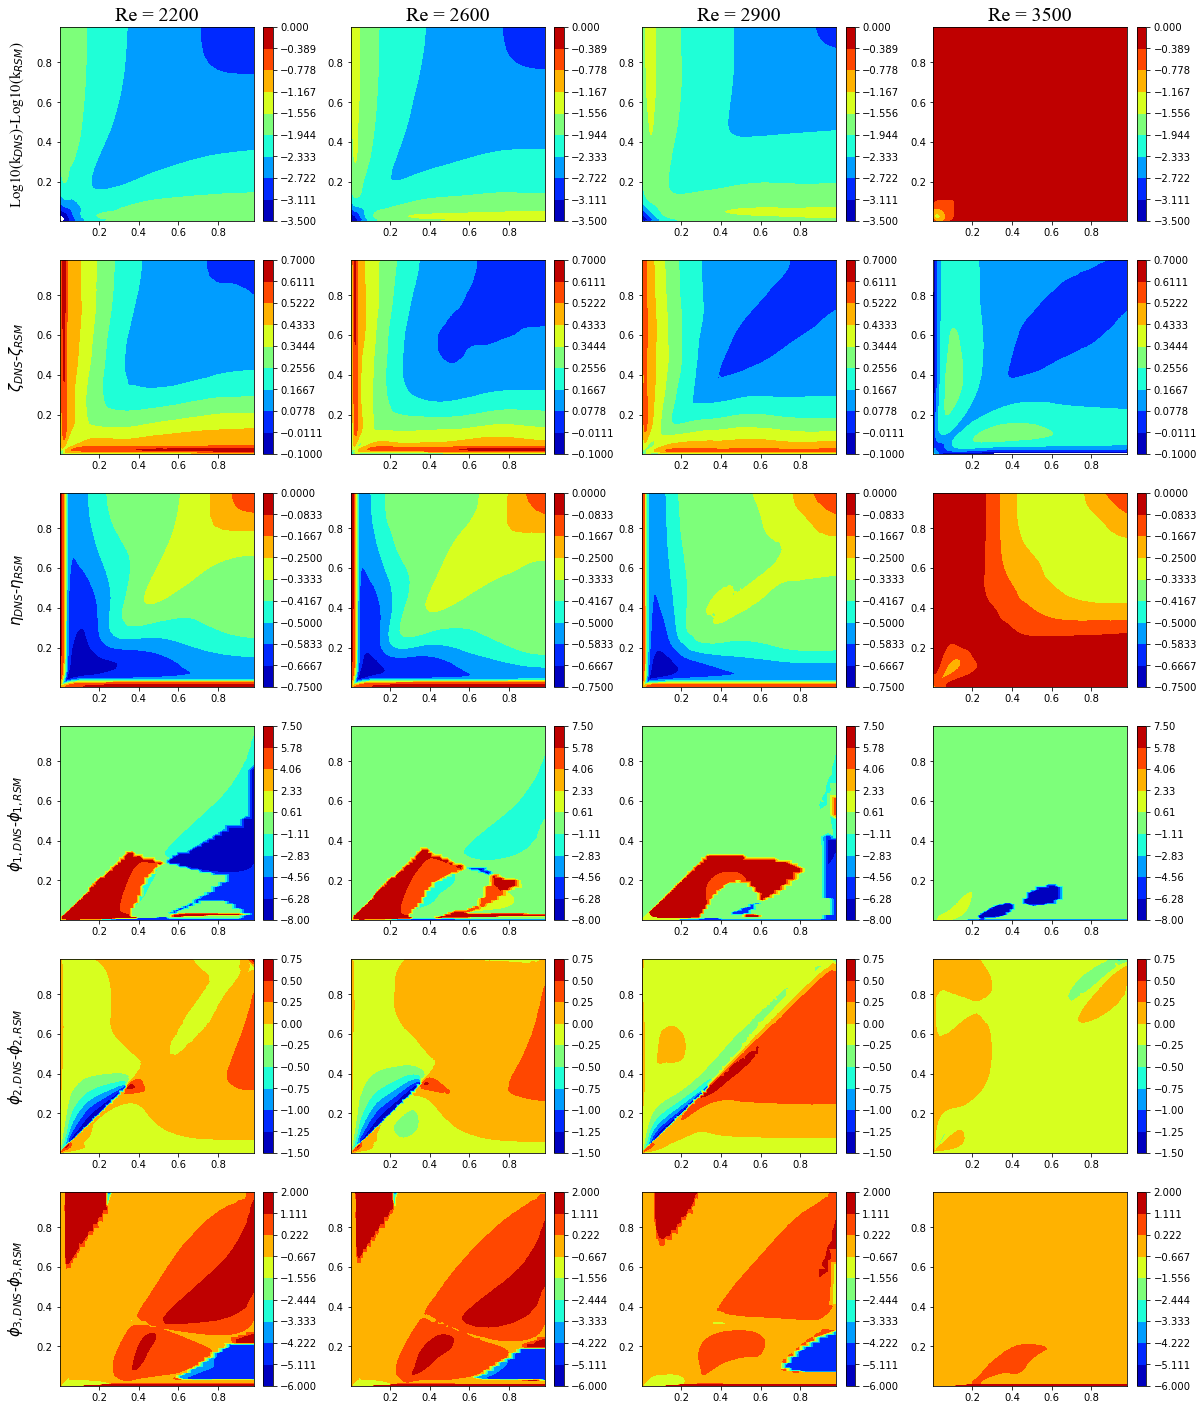

In [9]:
# train responses and test responses dataset visualization

import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np

fig = plt.figure(figsize=(20.0,25.0))
csfont = {'fontname':'Times New Roman'}
###################### Discrepancies on K: Log10(K_DNS)-Log10(K_RSM)
levelsk = np.linspace(-3.5, 0, 10)
ax1 = fig.add_subplot(6,4,1)    
contour1 = ax1.tricontourf(yHtrain[0:id,0],zHtrain[0:id,0],trainResponses[0:id,0],256,cmap=plt.cm.jet,levels=levelsk)
ax1.set_aspect('equal')
ax1.set_ylabel('Log10(k$_{DNS}$)-Log10(k$_{RSM}$)', rotation=90, fontsize=15, labelpad=10,**csfont)
cbar = plt.colorbar(contour1, fraction=0.046, pad=0.04)
plt.title('Re = 2200', fontsize=20,**csfont)

ax2 = fig.add_subplot(6,4,2) 
contour2 = ax2.tricontourf(yHtrain[id:2*id,0],zHtrain[id:2*id,0],trainResponses[id:2*id,0],256,cmap=plt.cm.jet,levels=levelsk)
ax2.set_aspect('equal')
cbar = plt.colorbar(contour2, fraction=0.046, pad=0.04)
plt.title('Re = 2600', fontsize=20,**csfont)

ax3 = fig.add_subplot(6,4,3) 
contour3 = ax3.tricontourf(yHtrain[2*id:3*id,0],zHtrain[2*id:3*id,0],trainResponses[2*id:3*id,0],256,cmap=plt.cm.jet,levels=levelsk)
ax3.set_aspect('equal')
cbar = plt.colorbar(contour3, fraction=0.046, pad=0.04)
plt.title('Re = 2900', fontsize=20,**csfont)

ax4 = fig.add_subplot(6,4,4) 
contour4 = ax4.tricontourf(yHtest[0:id,0],zHtest[0:id,0],testResponses[0:id,0],256,cmap=plt.cm.jet,levels=levelsk)
ax4.set_aspect('equal')
cbar = plt.colorbar(contour4, fraction=0.046, pad=0.04)
plt.title('Re = 3500', fontsize=20,**csfont)


######################  Discrepancies on zata: zeta_DNS-zeta_RSM
levelszeta = np.linspace(-0.1, 0.7, 10)
ax5 = fig.add_subplot(6,4,5)    
contour5 = ax5.tricontourf(yHtrain[0:id,0],zHtrain[0:id,0],trainResponses[0:id,1],256,cmap=plt.cm.jet, levels=levelszeta)
ax5.set_aspect('equal')
ax5.set_ylabel('$\zeta_{DNS}$-$\zeta_{RSM}$', rotation=90, fontsize=15, labelpad=10,**csfont)
cbar = plt.colorbar(contour5, fraction=0.046, pad=0.04)
#plt.title('Re = 2200', fontsize=20,**csfont)

ax6 = fig.add_subplot(6,4,6) 
contour6 = ax6.tricontourf(yHtrain[id:2*id,0],zHtrain[id:2*id,0],trainResponses[id:2*id,1],256,cmap=plt.cm.jet, levels=levelszeta)
ax6.set_aspect('equal')
cbar = plt.colorbar(contour6, fraction=0.046, pad=0.04)
#plt.title('Re = 2600', fontsize=20,**csfont)

ax7 = fig.add_subplot(6,4,7) 
contour7 = ax7.tricontourf(yHtrain[2*id:3*id,0],zHtrain[2*id:3*id,0],trainResponses[2*id:3*id,1],256,cmap=plt.cm.jet, levels=levelszeta)
ax7.set_aspect('equal')
cbar = plt.colorbar(contour7, fraction=0.046, pad=0.04)
#plt.title('Re = 2900', fontsize=20,**csfont)

ax8 = fig.add_subplot(6,4,8) 
contour8 = ax8.tricontourf(yHtest[0:id,0],zHtest[0:id,0],testResponses[0:id,1],256,cmap=plt.cm.jet, levels=levelszeta)
ax8.set_aspect('equal')
cbar = plt.colorbar(contour8, fraction=0.046, pad=0.04)
#plt.title('Re = 3500', fontsize=20,**csfont)

######################  Discrepancies on eta: eta_DNS-eta_RSM
levelseta = np.linspace(-0.75, 0, 10)
ax9 = fig.add_subplot(6,4,9)    
contour9 = ax9.tricontourf(yHtrain[0:id,0],zHtrain[0:id,0],trainResponses[0:id,2],256,cmap=plt.cm.jet, levels=levelseta)
ax9.set_aspect('equal')
ax9.set_ylabel('$\eta_{DNS}$-$\eta_{RSM}$', rotation=90, fontsize=15, labelpad=10,**csfont)
cbar = plt.colorbar(contour9, fraction=0.046, pad=0.04)
#plt.title('Re = 2200', fontsize=20,**csfont)

ax10 = fig.add_subplot(6,4,10) 
contour10 = ax10.tricontourf(yHtrain[id:2*id,0],zHtrain[id:2*id,0],trainResponses[id:2*id,2],256,cmap=plt.cm.jet, levels=levelseta)
ax10.set_aspect('equal')
cbar = plt.colorbar(contour10, fraction=0.046, pad=0.04)
#plt.title('Re = 2600', fontsize=20,**csfont)

ax11 = fig.add_subplot(6,4,11) 
contour11 = ax11.tricontourf(yHtrain[2*id:3*id,0],zHtrain[2*id:3*id,0],trainResponses[2*id:3*id,2],256,cmap=plt.cm.jet, levels=levelseta)
ax11.set_aspect('equal')
cbar = plt.colorbar(contour11, fraction=0.046, pad=0.04)
#plt.title('Re = 2900', fontsize=20,**csfont)

ax12 = fig.add_subplot(6,4,12) 
contour12 = ax12.tricontourf(yHtest[0:id,0],zHtest[0:id,0],testResponses[0:id,2],256,cmap=plt.cm.jet, levels=levelseta)
ax12.set_aspect('equal')
cbar = plt.colorbar(contour12, fraction=0.046, pad=0.04)
#plt.title('Re = 3500', fontsize=20,**csfont)

######################  Discrepancies on zata: phi1_DNS-phi1_RSM
levelsphi1 = np.linspace(-8, 7.5, 10)
ax13 = fig.add_subplot(6,4,13)    
contour13 = ax13.tricontourf(yHtrain[0:id,0],zHtrain[0:id,0],trainResponses[0:id,3],256,cmap=plt.cm.jet, levels=levelsphi1)
ax13.set_aspect('equal')
ax13.set_ylabel('$\phi_{1,DNS}$-$\phi_{1,RSM}$', rotation=90, fontsize=15, labelpad=10,**csfont)
cbar = plt.colorbar(contour13, fraction=0.046, pad=0.04)
#plt.title('Re = 2200', fontsize=20,**csfont)

ax14 = fig.add_subplot(6,4,14) 
contour14 = ax14.tricontourf(yHtrain[id:2*id,0],zHtrain[id:2*id,0],trainResponses[id:2*id,3],256,cmap=plt.cm.jet, levels=levelsphi1)
ax14.set_aspect('equal')
cbar = plt.colorbar(contour14, fraction=0.046, pad=0.04)
#plt.title('Re = 2600', fontsize=20,**csfont)

ax15 = fig.add_subplot(6,4,15) 
contour15 = ax15.tricontourf(yHtrain[2*id:3*id,0],zHtrain[2*id:3*id,0],trainResponses[2*id:3*id,3],256,cmap=plt.cm.jet, levels=levelsphi1)
ax15.set_aspect('equal')
cbar = plt.colorbar(contour15, fraction=0.046, pad=0.04)
#plt.title('Re = 2900', fontsize=20,**csfont)

ax16 = fig.add_subplot(6,4,16) 
contour16 = ax16.tricontourf(yHtest[0:id,0],zHtest[0:id,0],testResponses[0:id,3],256,cmap=plt.cm.jet, levels=levelsphi1)
ax16.set_aspect('equal')
cbar = plt.colorbar(contour16, fraction=0.046, pad=0.04)
#plt.title('Re = 3500', fontsize=20,**csfont)

######################  Discrepancies on zata: phi2_DNS-phi2_RSM
levelsphi2 = np.linspace(-1.5, 0.75, 10)
ax17= fig.add_subplot(6,4,17)    
contour17 = ax17.tricontourf(yHtrain[0:id,0],zHtrain[0:id,0],trainResponses[0:id,4],256,cmap=plt.cm.jet, levels=levelsphi2)
ax17.set_aspect('equal')
ax17.set_ylabel('$\phi_{2,DNS}$-$\phi_{2,RSM}$', rotation=90, fontsize=15, labelpad=10,**csfont)
cbar = plt.colorbar(contour17, fraction=0.046, pad=0.04)
#plt.title('Re = 2200', fontsize=20,**csfont)

ax18 = fig.add_subplot(6,4,18) 
contour18 = ax18.tricontourf(yHtrain[id:2*id,0],zHtrain[id:2*id,0],trainResponses[id:2*id,4],256,cmap=plt.cm.jet, levels=levelsphi2)
ax18.set_aspect('equal')
cbar = plt.colorbar(contour18, fraction=0.046, pad=0.04)
#plt.title('Re = 2600', fontsize=20,**csfont)

ax19 = fig.add_subplot(6,4,19) 
contour19 = ax19.tricontourf(yHtrain[2*id:3*id,0],zHtrain[2*id:3*id,0],trainResponses[2*id:3*id,4],256,cmap=plt.cm.jet, levels=levelsphi2)
ax19.set_aspect('equal')
cbar = plt.colorbar(contour19, fraction=0.046, pad=0.04)
#plt.title('Re = 2900', fontsize=20,**csfont)

ax20 = fig.add_subplot(6,4,20) 
contour20 = ax20.tricontourf(yHtest[0:id,0],zHtest[0:id,0],testResponses[0:id,4],256,cmap=plt.cm.jet, levels=levelsphi2)
ax20.set_aspect('equal')
cbar = plt.colorbar(contour20, fraction=0.046, pad=0.04)
#plt.title('Re = 3500', fontsize=20,**csfont)

######################  Discrepancies on zata: phi3_DNS-phi3_RSM
levelsphi3 = np.linspace(-6, 2, 10)
ax21= fig.add_subplot(6,4,21)    
contour21 = ax21.tricontourf(yHtrain[0:id,0],zHtrain[0:id,0],trainResponses[0:id,5],256,cmap=plt.cm.jet, levels=levelsphi3)
ax21.set_aspect('equal')
ax21.set_ylabel('$\phi_{3,DNS}$-$\phi_{3,RSM}$', rotation=90, fontsize=15, labelpad=10,**csfont)
cbar = plt.colorbar(contour21, fraction=0.046, pad=0.04)
#plt.title('Re = 2200', fontsize=20,**csfont)

ax22 = fig.add_subplot(6,4,22) 
contour22 = ax22.tricontourf(yHtrain[id:2*id,0],zHtrain[id:2*id,0],trainResponses[id:2*id,5],256,cmap=plt.cm.jet, levels=levelsphi3)
ax22.set_aspect('equal')
cbar = plt.colorbar(contour22, fraction=0.046, pad=0.04)
#plt.title('Re = 2600', fontsize=20,**csfont)

ax23 = fig.add_subplot(6,4,23) 
contour23 = ax23.tricontourf(yHtrain[2*id:3*id,0],zHtrain[2*id:3*id,0],trainResponses[2*id:3*id,5],256,cmap=plt.cm.jet, levels=levelsphi3)
ax23.set_aspect('equal')
cbar = plt.colorbar(contour23, fraction=0.046, pad=0.04)
#plt.title('Re = 2900', fontsize=20,**csfont)

ax24 = fig.add_subplot(6,4,24) 
contour24 = ax24.tricontourf(yHtest[0:id,0],zHtest[0:id,0],testResponses[0:id,5],256,cmap=plt.cm.jet, levels=levelsphi3)
ax24.set_aspect('equal')
cbar = plt.colorbar(contour24, fraction=0.046, pad=0.04)
#plt.title('Re = 3500', fontsize=20,**csfont)
    
    
plt.show()
#fig.savefig("test_rasterization.pdf")

In [358]:
## Import system modules

# sklearn importing
from sklearn.ensemble._forest import RandomForestRegressor

# keras importing
from keras.models import Sequential
from keras.layers import Dense

import time

In [10]:
def randomForest(trainFeatures, trainResponses, testFeatures, maxFeatures = 'log2', nTree=100):
    ## Settings of random forests regressor
    regModel = RandomForestRegressor(n_estimators=nTree, max_features=maxFeatures)    
    ## Train the random forests regressor
    regModel.fit(trainFeatures, trainResponses)
    ## Prediction
    testResponsesPred = regModel.predict(testFeatures)
    return testResponsesPred
    

In [11]:
trainFeatures.shape

(12675, 10)

In [267]:
# if __name__== "__main__":
    # Load data
time_begin_RF = time.time()
# Make prediction via the random forest regressor
testResponsesPred_RF = randomForest(trainFeatures, trainResponses, testFeatures, 5, 100)
time_end_RF = time.time()
RFtimeCost = time_end_RF-time_begin_RF

#filename = 'C:/Users/HERASAT-6/Desktop/test-discs.txt'
#data = np.concatenate((yHtest, zHtest, testResponses), axis=1)  
#np.savetxt(filename, data)

#filename = 'C:/Users/HERASAT-6/Desktop/RF-predicted-discs.txt'
#data = np.concatenate((yHtest, zHtest, testResponsesPred_RF), axis=1)  
#np.savetxt(filename, data)


<ipython-input-10-5f8543d68ef0>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regModel.fit(trainFeatures, trainResponses)


In [268]:
from numpy import mean, sqrt, square
from sklearn.metrics import r2_score

error=testResponsesPred_RF-testResponses
rms = sqrt(mean(square(error)))
print(rms)
r2_score(testResponses, testResponsesPred_RF)

0.31525590470365195


-18.09285532102394

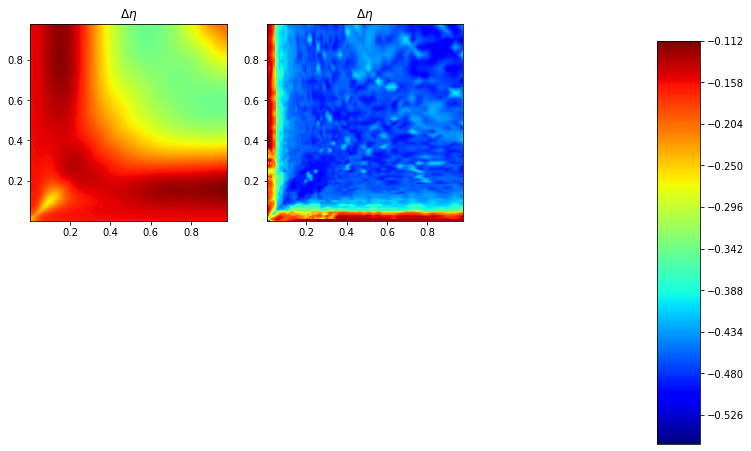

In [308]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np


#x = np.asarray([8, 10, 8, 14, 9, 11, 13, 10, 12, 11])
#y = np.asarray([2, 2, 2, 2, 2.56666667, 2.56666667, 2.56666667, 3.13333333, 3.13333333, 3.7])
#z = np.cos(2.5*x*x)*np.cos(1.5*y*x)
#triangles = [[0, 3, 9]]

#triang = mtri.Triangulation(x, y, triangles)


#fig, ax = plt.subplots()

#t = ax.tricontourf(triang, z)
#plt.colorbar(t)

fig = plt.figure(figsize=(12.0,8.0))
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

ax1 = fig.add_subplot(231)    
contour1 = ax1.tricontourf(data[3*id:,0],data[3*id:,1],testResponses[:,0],256,cmap=plt.cm.jet, vmin=-0.6,vmax=0)
ax1.set_aspect('equal')
#fig.colorbar(contour1, cax=cbar_ax)
#cbar = plt.colorbar(contour1)
plt.title(r'$\Delta \eta$')

ax2 = fig.add_subplot(232)    
contour2 = ax2.tricontourf(data[3*id:,0],data[3*id:,1],testResponsesPred_RF,256,cmap=plt.cm.jet)
ax2.set_aspect('equal')
fig.colorbar(contour2, cax=cbar_ax)
#cbar = plt.colorbar(contour2)
plt.title(r'$\Delta \eta$')






plt.show()


In [276]:
testResponses[:,0].shape

(4225,)

In [33]:
(xList, yList, emptyArray)


([0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 array([[20., 10.,  0.,  0.,  0.],
        [ 5.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]]))

In [130]:
def keras_nn(trainFeatures, trainResponses, testFeatures, Nepochs = 100):
    
    '''
    This function is to construct neural network based on the training data and predict the 
    response given test data.
    Two hidded layers are used, the number of neurals are 64 and 32, respectively.
    '''
    model = Sequential()
    # The first hidder layer of NN
    model.add(Dense(64, input_dim=trainFeatures.shape[1], activation='relu'))
    # The second hidder layer of NN
    model.add(Dense(32, activation='relu'))
    #model.add(Dense(6, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # Training
    model.fit(trainFeatures, trainResponses, epochs=Nepochs, batch_size=200, verbose=0)
    # Prediction
    testResponsesPred = model.predict(testFeatures)
    return testResponsesPred

In [126]:
trainResponses[:,0].shape

(12675,)

In [131]:
time_begin_NN = time.time()
# Make prediction via the neural network

testResponsesPred_NN = keras_nn(trainFeatures, trainResponses, testFeatures, Nepochs=100)
time_end_NN = time.time()
NNtimeCost = time_end_NN-time_begin_NN
NNtimeCost

5.331983327865601

In [132]:
from numpy import mean, sqrt, square
error=testResponsesPred_NN-testResponses
rms = sqrt(mean(square(error)))
rms

0.8357546018879275

In [15]:
testResponses

array([[-0.365979,  0.0579  , -0.1209  , -0.056909, -0.488509,  0.082488],
       [-0.360109,  0.058   , -0.1316  ,  0.416986,  0.045539, -0.362044],
       [-0.349375,  0.0595  , -0.1519  ,  0.345951,  0.016824, -0.288765],
       ...,
       [-0.529814,  0.162   , -0.178111,  0.325052,  0.53289 , -0.230855],
       [-0.447749,  0.2685  , -0.275525,  0.263134,  0.189576, -0.221275],
       [-0.699636,  0.528   , -0.661006,  0.960096, -0.272435, -0.617372]])